<a href="https://colab.research.google.com/github/arizzi/NNTutorial/blob/master/Solutions_CNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial on CNN
We try to build a DNN that recognize if an image contains a rectangle or a circle

## Import useful stuff

In [1]:
from keras.layers import Input,Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization
from keras.models import Model
import numpy as np
from math import *
from matplotlib import pyplot as plt 

Using TensorFlow backend.


## Lets generate some data

We now generate ourself some images with a circle or a rectangle, of random color, in a random position

### Exercise
1. Try adding more classes such e.g.  Lines or Ellipses

2. Try adding some random noise in the image background

Let's show one of the generated image

In [0]:
import cv2

def randomColor():
  return  int(np.random.rand()*256),int(np.random.rand()*256),int(np.random.rand()*256)

def addNoise(img):
  for x in range(img.shape[0]) :
    for y in range(img.shape[1]):
      img[x][y]+=np.array(randomColor(), dtype=np.uint8)

def drawCircle(c,x,y,r):
  img = np.zeros((64,64,3), np.uint8)
  addNoise(img)
  cv2.circle(img,(x,y),r,c, -1)
  return img

def genCircle():
  return drawCircle(randomColor(),int(np.random.rand()*30)+10,int(np.random.rand()*30)+10,
                    int(np.random.rand()*12)+5)

def drawRectangle(c,x,y,w,h):
  img = np.zeros((64,64,3), np.uint8)
  addNoise(img)
  cv2.rectangle(img,(x,y),((x+w),(y+h)), c, -1)
  return img

def drawLine(c,x,y,w,h):
  img = np.zeros((64,64,3), np.uint8)
  addNoise(img)
  cv2.line(img,(x,y),((x+w),(y+h)), c, 1)
  return img

def genRectangle():
  return drawRectangle(randomColor(),int(np.random.rand()*30)+10,int(np.random.rand()*30)+10,
                       int(np.random.rand()*12)+5,int(np.random.rand()*12)+5)

def genRectangle():
  return drawRectangle(randomColor(),int(np.random.rand()*30)+10,int(np.random.rand()*30)+10,
                       int(np.random.rand()*12)+5,int(np.random.rand()*12)+5)
def genLine():
  return drawLine(randomColor(),int(np.random.rand()*30)+10,int(np.random.rand()*30)+10,
                       int(np.random.rand()*12)+5,int(np.random.rand()*12)+5)


nsamples=1000
lines=np.stack([genLine() for x in range(nsamples)])
rects=np.stack([genRectangle() for x in range(nsamples)])
circs=np.stack([genCircle() for x in range(nsamples)])


(1000, 64, 64, 3)


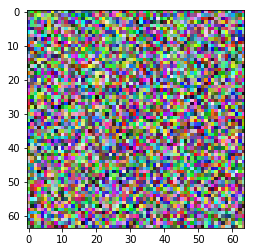

In [3]:

print(lines.shape)
plt.imshow(lines[1])


We concatenate zeroes and ones as labels and the shuffle with the same permutation both the data and the labels.
## Exercise
3. If we have more categories (let say N) we should use a categorical label that is a vector of length N with 1 on the category(/ies) the image belong to and 0 in the others. Try to build a categorical label for two categories 
4. Expand the categorical label to Triangles, Ellispes, Lines  and possibly also non exclusive categories such has Polygons, 2DObjects, Conicals 

In [0]:
circ_cat=np.tile(np.asarray([0,1,0]),(circs.shape[0],1))
rect_cat=np.tile(np.asarray([1,0,0]),(rects.shape[0],1))
line_cat=np.tile(np.asarray([0,0,1]),(lines.shape[0],1))
lc=circs+lines
lc_cat=circ_cat+line_cat

categorical_labels=np.concatenate((rect_cat,circ_cat,line_cat))
data=np.concatenate((rects,circs,lines))

permutation = np.random.permutation(data.shape[0])
data=data[permutation]
categorical_labels=categorical_labels[permutation]



# Let's build a CNN 

Now we build our first CNN. We have some Conv layers interleaved with MaxPooling

Finally we flatten the output of the convolutional stack and appply a Dense FF

### MaxPooling
![alt text](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

### Exercise
5. Try adding/removing convolutional layers, change the kernel size.
6. Try changing the model to categorical labels, change loss function from binary_crossentropy to categorical_crossentropy


In [5]:
inputs=Input(shape=(64,64,3,))
hidden=  Conv2D(9,(5,5), activation='relu')(inputs)
#hidden= BatchNormalization()(hidden)
hidden= Dropout(0.05)(hidden)
#hidden= MaxPooling2D((3,3))(hidden)
hidden=  Conv2D(3,(3,3), activation='relu')(hidden)
hidden= MaxPooling2D((10,10))(hidden)
hidden=  Conv2D(3,(3,3), activation='relu')(hidden)
hidden= MaxPooling2D((2,2))(hidden)
hidden= Flatten()(hidden)
hidden=  Dense(10, activation='relu')(hidden)
hidden=  Dense(10, activation='relu')(hidden) 
hidden=  Dense(10, activation='relu')(hidden)
outputs = Dense(3, activation='softmax')(hidden)
model = Model(input=inputs, output=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 9)         684       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 3)         246       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 3)           0         
_________________________________________________________________
conv2d_3 (Conv2D)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


And now let's fit it to our data.
The sample is automatically split in two so that 50% of it is used for validation and the other half for training


In [6]:
history=model.fit(data,categorical_labels,validation_split=0.5,epochs=30)

Instructions for updating:
Use tf.cast instead.
Train on 1500 samples, validate on 1500 samples
Epoch 1/30
1500/1500 [==============================] - 15s 10ms/step - loss: 2.2209 - acc: 0.3447 - val_loss: 1.0601 - val_acc: 0.4033
Epoch 2/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0916 - acc: 0.3520 - val_loss: 1.0608 - val_acc: 0.3973
Epoch 3/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0906 - acc: 0.3687 - val_loss: 1.0591 - val_acc: 0.3827
Epoch 4/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0793 - acc: 0.3833 - val_loss: 1.0457 - val_acc: 0.4307
Epoch 5/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0654 - acc: 0.4173 - val_loss: 1.0432 - val_acc: 0.4413
Epoch 6/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0683 - acc: 0.4200 - val_loss: 1.0532 - val_acc: 0.4307
Epoch 7/30
1500/1500 [==============================] - 15s 10ms/step - loss: 1.0598 - a

*history* contains information about the training.  We can now now show the loss vs epoch for both validation and training samples.




dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


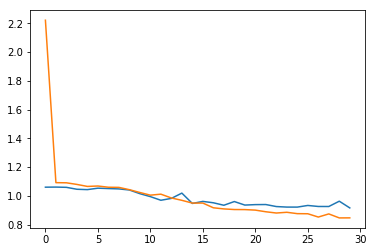

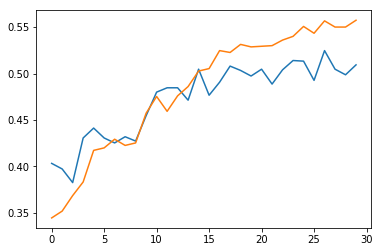

In [7]:
print(history.history.keys())
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])
plt.show()


In [8]:
print(model.predict(np.expand_dims(genRectangle(),axis=0) ))
print(model.predict(np.expand_dims(genCircle(),axis=0) ))


[[0.39394167 0.15009494 0.45596343]]
[[3.5545923e-02 9.6367061e-01 7.8343396e-04]]


Let's try to mix an image with circles and rectangles and see how the network would evaluate it 

[[0.39394167 0.15009494 0.45596343]]
0.39  rectangle
0.15  circle
0.46  line


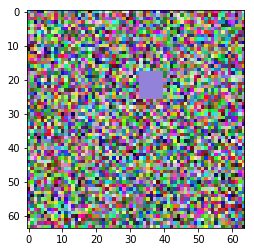

In [9]:
im=genRectangle()
pr=model.predict(np.expand_dims(im,axis=0) )
print(pr)
print("%0.2f  rectangle"%pr[0][0])
print("%0.2f  circle"%pr[0][1])
print("%0.2f  line"%pr[0][2])
plt.imshow(im)

The following code can be used to visualize what features the first conv layer is looking at

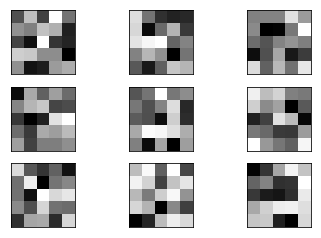

In [10]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()